## House Prices dataset

In [1]:
# Librerías base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para el workflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Evitar warnings
import warnings
warnings.filterwarnings("ignore")

### Cargar los datos

In [2]:
# Cargar los datos
data = pd.read_csv('https://raw.githubusercontent.com/jorge-robledo11/Datasets/main/Datasets/houseprice.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Crea una lista de los tipos de variables
categorical = [col for col in data.columns if data[col].dtype == 'object']

year_vars = [col for col in data.columns if 'Yr' in col or 'Year' in col]

discrete = [
    col for col in data.columns if data[col].dtype != 'object'
    and len(data[col].unique()) < 20 and col not in year_vars
]

numerical = [
    col for col in data.columns if data[col].dtype != 'object'
    if col not in discrete and col not in ['Id', 'SalePrice']
    and col not in year_vars
]

print('Hay {} variables continuas '.format(len(numerical)))
print('Hay {} variables discretas'.format(len(discrete)))
print('Hay {} variables temporales'.format(len(year_vars)))
print('Hay {} variables categóricas'.format(len(categorical)))

Hay 18 variables continuas 
Hay 14 variables discretas
Hay 4 variables temporales
Hay 43 variables categóricas


### Separar sets de training y test 

In [4]:
# Separemos los datos en sets de entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.20,
                                                    random_state=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1168, 79) (292, 79)
(1168,) (292,)


In [5]:
# Calculemos el tiempo transcurrido
def elapsed_years(df, var):
    
    # Captura la diferencia entre la variable año var y el año de construcción de la casa
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [6]:
# Eliminar la variable YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [7]:
# Captura el nombre de las columnas para usarlas más adelante en el notebook
final_columns = X_train.columns

In [8]:
# Vamos a manipular las variables discretas como si fueran categóricas 
# para lograrlo usando Feature-engine necesitamos modificar el tipo  de variables a una tipo 'object'

X_train[discrete] = X_train[discrete].astype('object')
X_test[discrete] = X_test[discrete].astype('object')

## Pipeline de Ingeniería de Variables

### 1. Imputación de datos nulos

In [9]:
from Funciones import nan_values

In [10]:
# Categóricas
nan_values(data=data, variables=categorical, variable_type='Categóricas:')

Variables Categóricas:
Alley 93.767%
MasVnrType 0.548%
BsmtQual 2.534%
BsmtCond 2.534%
BsmtExposure 2.603%
BsmtFinType1 2.534%
BsmtFinType2 2.603%
Electrical 0.068%
FireplaceQu 47.26%
GarageType 5.548%
GarageFinish 5.548%
GarageQual 5.548%
GarageCond 5.548%
PoolQC 99.521%
Fence 80.753%
MiscFeature 96.301%


In [11]:
# Continuas
nan_values(data=data, variables=numerical, variable_type='Continuas:')

Variables Continuas:
LotFrontage 17.74%
MasVnrArea 0.548%


In [12]:
# Discretas
nan_values(data=data, variables=discrete, variable_type='Discretas:')

Variables Discretas:


In [13]:
# Temporales
nan_values(data=data, variables=year_vars, variable_type='Temporales:')

Variables Temporales:
GarageYrBlt 5.548%


Algunas **variables categóricas** tienen un alto porcentaje de datos faltantes. Estas deberán ser tratadas de manera diferente. Empecemos primero por las categóricas

In [14]:
# Capturemos las variables con alto porcentaje de datos faltantes (más del 5%)
categorical_more_than_5perc = [var for var in categorical if data[var].isnull().mean() > 0.05]
print(f'Variables categóricas por encima del 5% de datos faltantes:\n{categorical_more_than_5perc}')
print()

# Capturemos las variables con menor porcentaje de datos faltantes (menos del 5%)
categorical_less_than_5perc = [var for var in categorical if data[var].isnull().sum() > 0 and data[var].isnull().mean() <= 0.05]
print(f'Variables categóricas por debajo del 5% de datos faltantes:\n{categorical_less_than_5perc}')

Variables categóricas por encima del 5% de datos faltantes:
['Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Variables categóricas por debajo del 5% de datos faltantes:
['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical']


Existen dos variables con porcentaje muy bajo de datos faltantes ('Electrical' y 'MasVnrType'). Una técnica que se podría aplicar para esos casos es CCA. Sin embargo, como es una mala práctica para modelos en producción, por el momento no la vamos aplicar. En el caso de categorías con datos faltantes de más del 5% se aplicará la categoría 'missing' mientras que para el resto, primero veamos la frecuencia de las distintas categorías que tienen dichas variables.

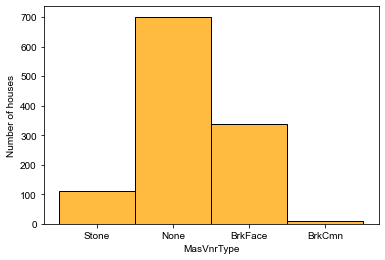

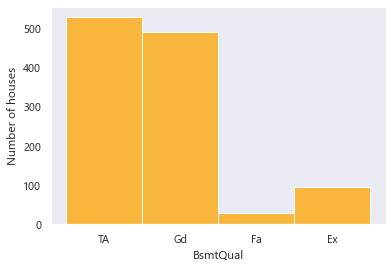

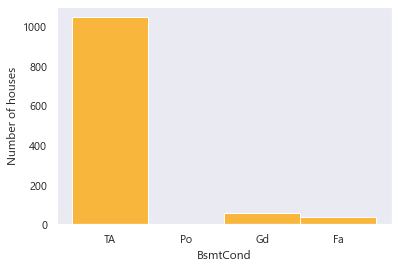

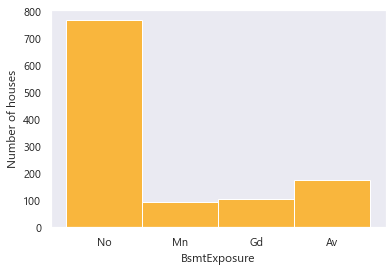

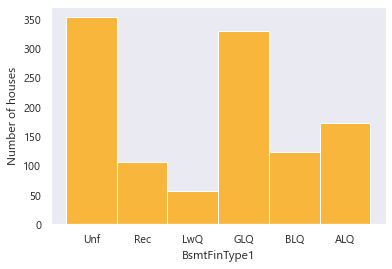

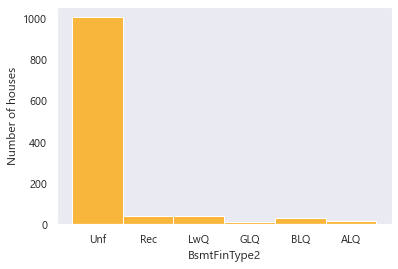

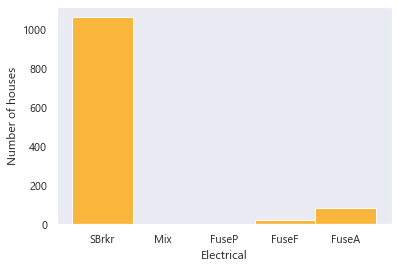

In [15]:
for var in categorical_less_than_5perc:
    sns.histplot(X_train[var].sort_values(ascending=False), color='orange')
    plt.xlabel(var)
    plt.ylabel('Number of houses')
    plt.show()

In [16]:
# Por medio del histplot obtenemos las 3 variables que se encuentran medianamente iguales en su distribución
categorical_less_5perc_random = ['BsmtQual','BsmtFinType1','MasVnrType']
categorical_less_5perc_most_frequent = [var for var in categorical_less_than_5perc if var not in categorical_less_5perc_random] 

print(f'Variables categóricas por debajo del 5% de datos faltantes de manera aleatoria:\n{categorical_less_5perc_random}')
print()
print(f'Variables categóricas por debajo del 5% de datos faltantes de manera más frequente:\n{categorical_less_5perc_most_frequent}')

Variables categóricas por debajo del 5% de datos faltantes de manera aleatoria:
['BsmtQual', 'BsmtFinType1', 'MasVnrType']

Variables categóricas por debajo del 5% de datos faltantes de manera más frequente:
['BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'Electrical']


Cabe mencionar que las variables categóricas las cuales tendrán **indicador de ausencia**, serán todas excepto las que se encuentran en 'categorical_more_than_5perc'. Nos quedan analizar las variables numéricas 'LotFrontage', 'MasVnrArea' y 'GarageYrBlt'. La que mayor porcentaje de valores ausentes tiene es 'LotFrontage'. Estudiemos la distribución de estas variables.

In [17]:
from Funciones import diagnostic_plots

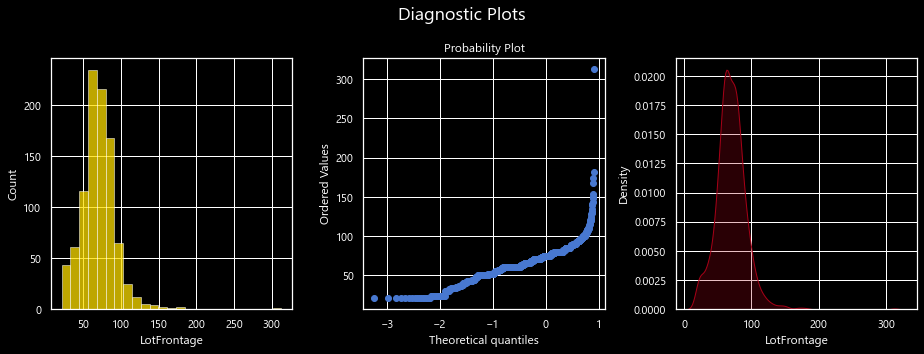

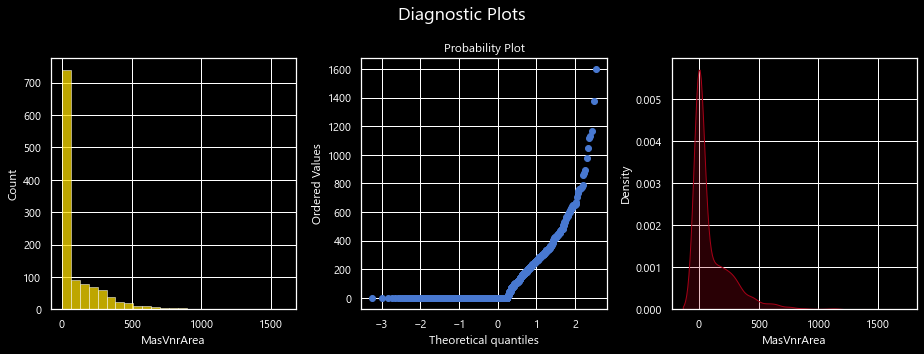

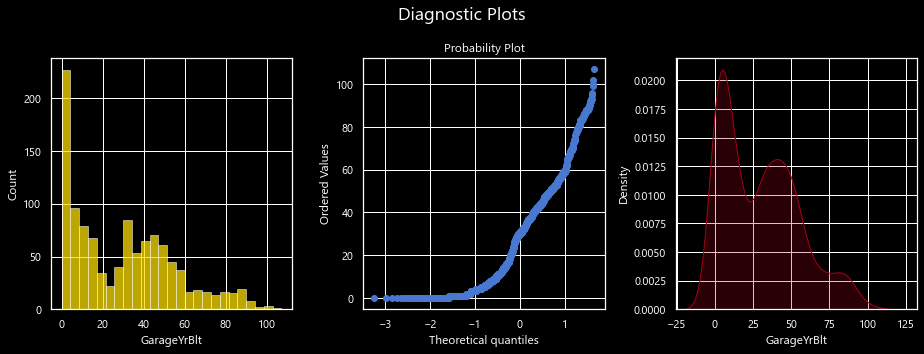

In [18]:
for var in ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']:
    diagnostic_plots(X_train, var)

Para el caso de ambas utilizaremos la imputación por **muestra aleatoria** mientras que para la otra, aplicaremos la sustitución por la mediana. Por tanto, estas tres variables también tendrán indicador de ausencia.

In [19]:
# Capturar el nombre de las columnas para usarlas más adelante en el notebook
missing_indicator_columns = [str(var) + '_nan' for var in ['LotFrontage','MasVnrArea','GarageYrBlt'] + categorical_less_than_5perc]
final_columns = list(X_train.columns) + missing_indicator_columns

### 2. Codifacición de variables categóricas
Vamos a estudiar la cardinalidad de nuestras variables categóricas

In [20]:
def plot_categories(dataframe, cols, ylabel = 'Porcentaje de casas'):
    
    for col in cols:
        temp_dataframe = pd.Series(dataframe[col].value_counts() / len(dataframe))

        # Graficar con los porcentajes
        fig = temp_dataframe.sort_values(ascending=False).plot.bar(color='#3f888f')
        fig.set_xlabel(col)

        # Anadir línea a 5% para resaltar categorias poco comunes
        fig.axhline(y=0.05, color='#e51a4c')
        fig.set_ylabel(ylabel)
        
        plt.grid()
        plt.show()

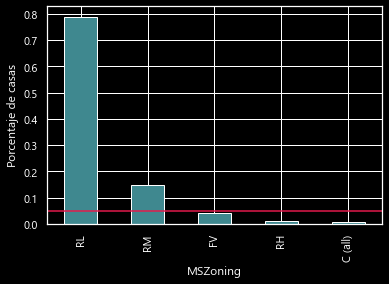

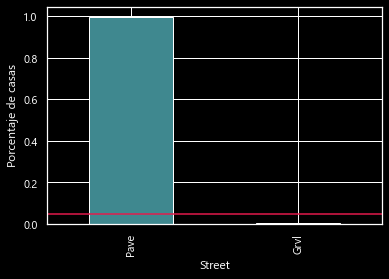

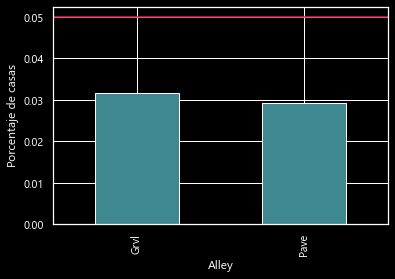

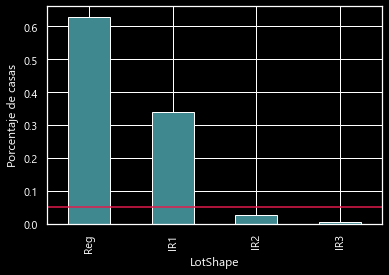

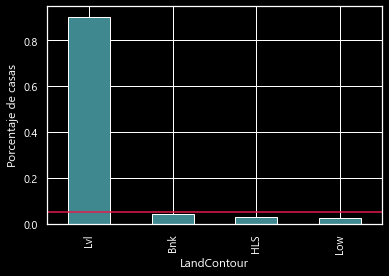

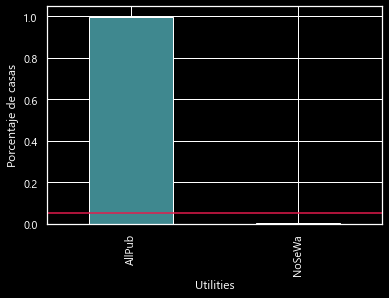

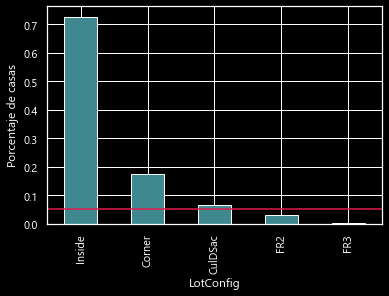

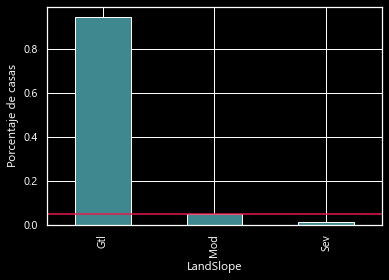

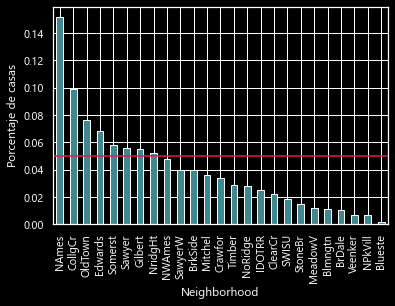

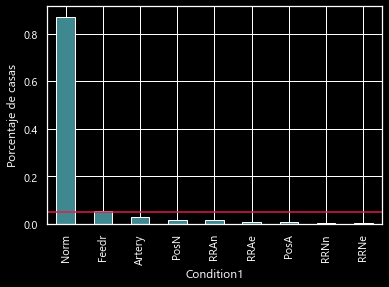

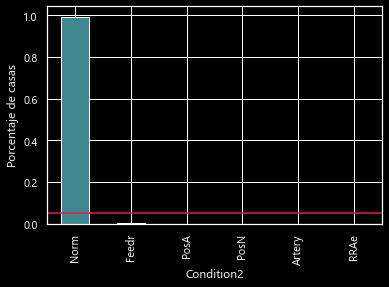

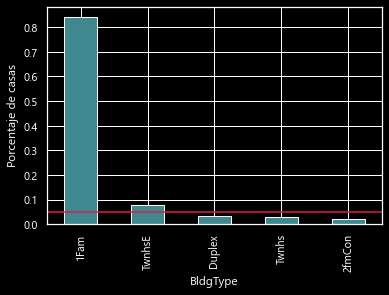

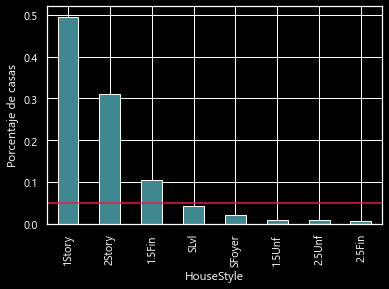

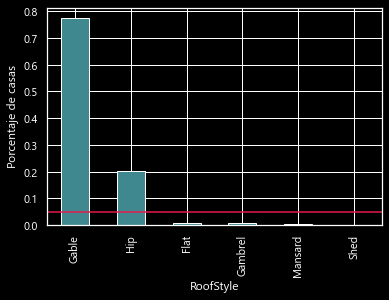

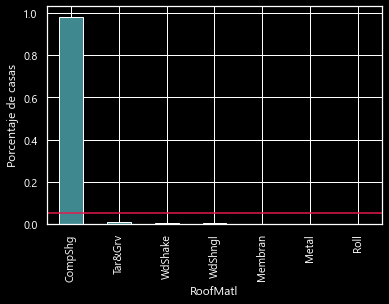

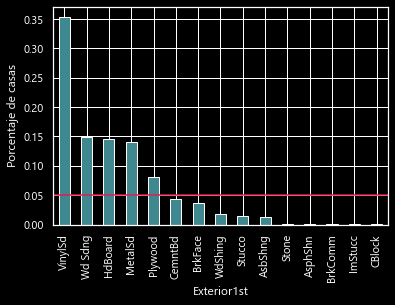

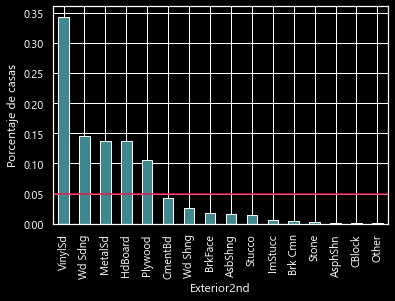

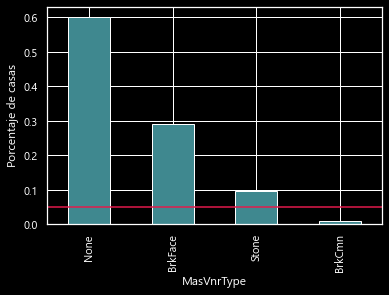

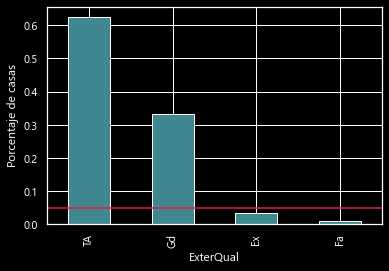

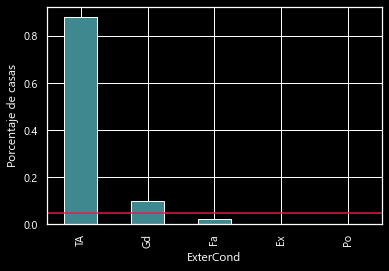

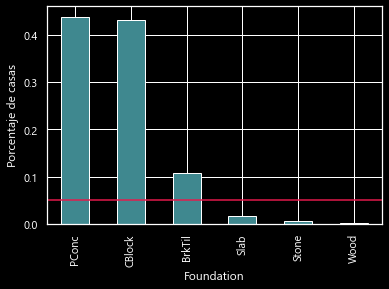

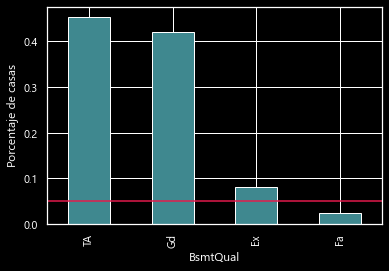

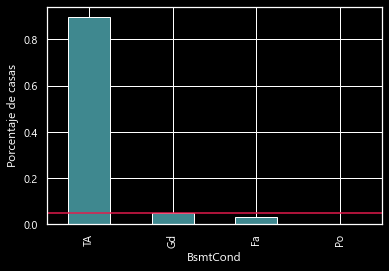

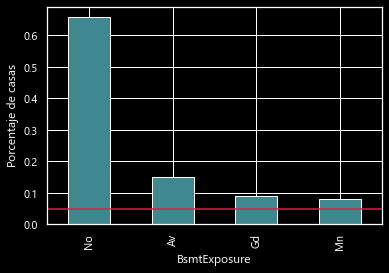

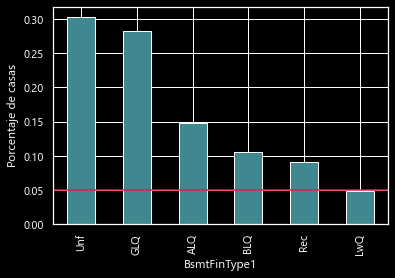

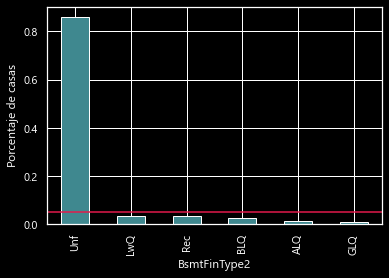

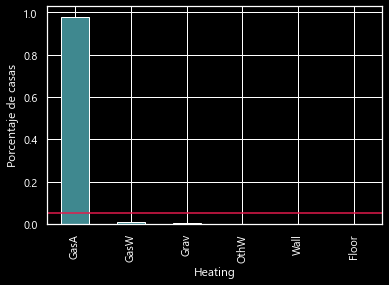

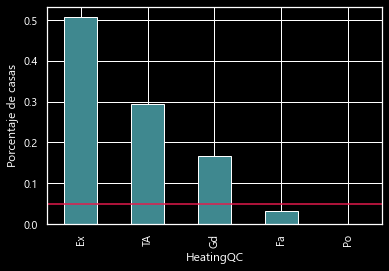

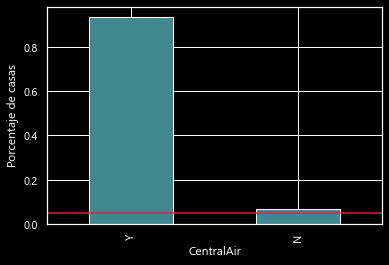

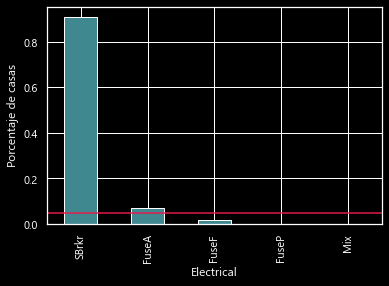

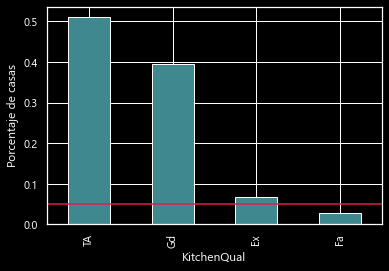

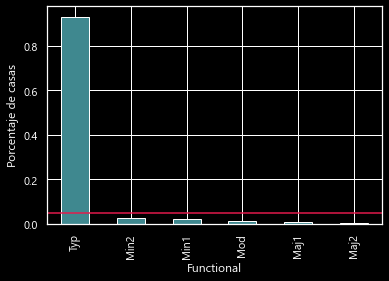

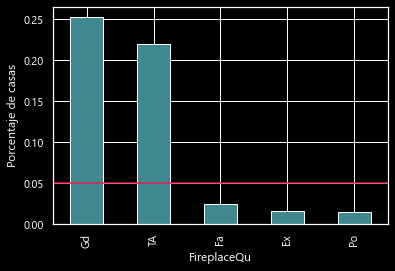

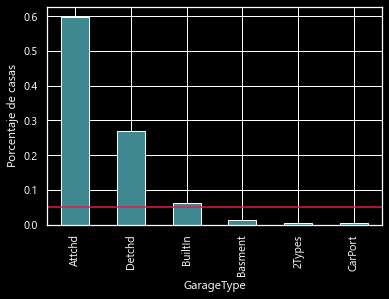

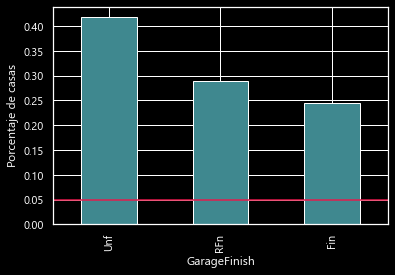

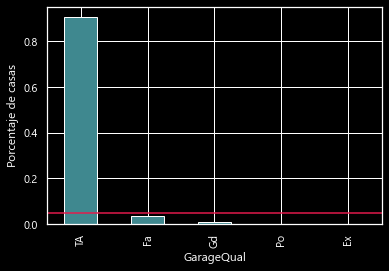

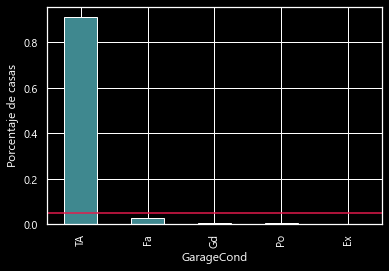

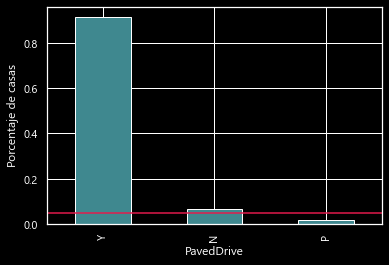

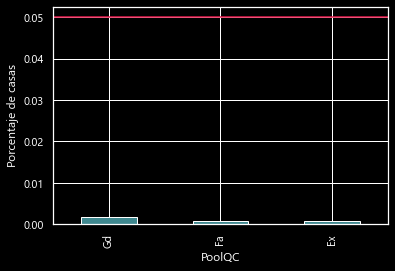

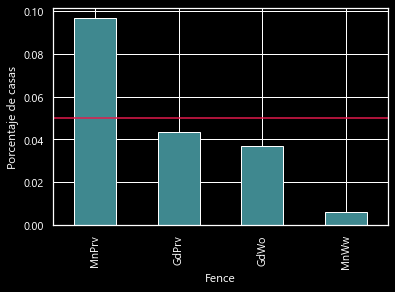

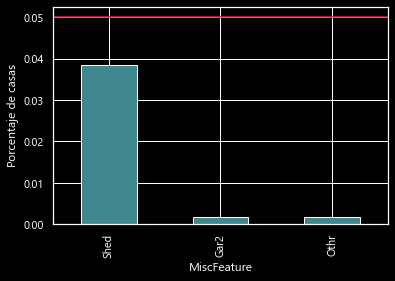

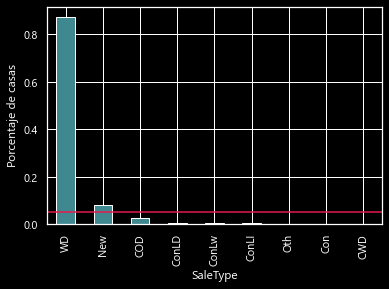

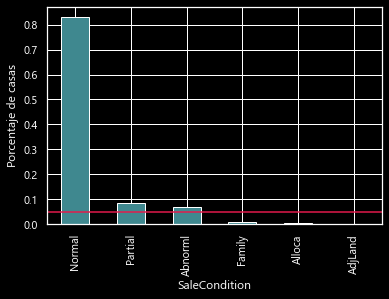

In [21]:
plot_categories(X_train, categorical)

In [22]:
# Variables categóricas con alta cardinalidad y baja cardinalidad
categorical_high_cardinality = ['BsmtFinType1', 'Exterior2nd', 'Exterior1st', 'Neighborhood']
categorical_low_cardinality = [cat for cat in categorical if cat not in categorical_high_cardinality]

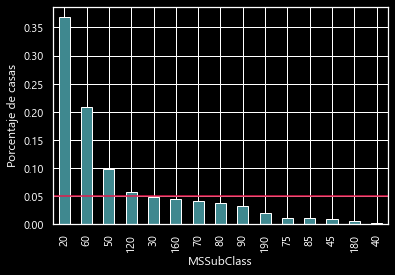

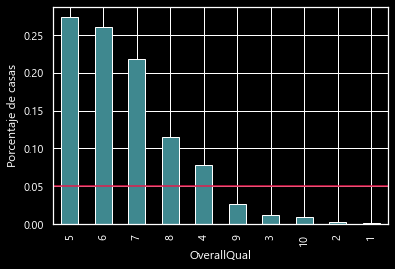

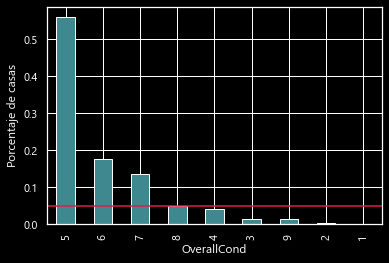

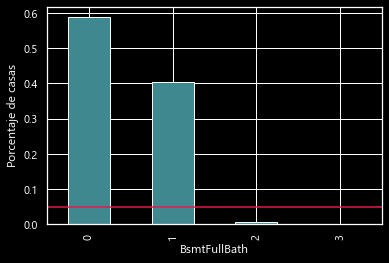

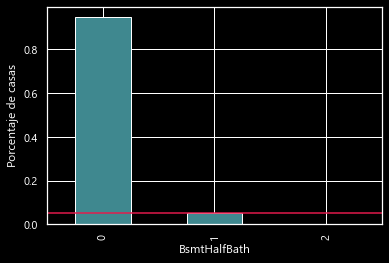

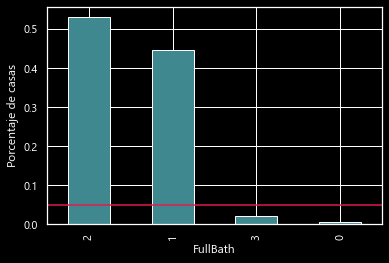

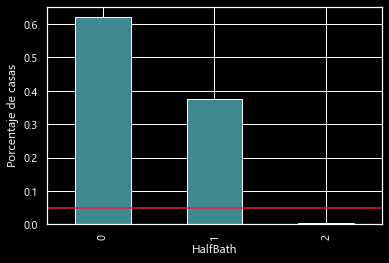

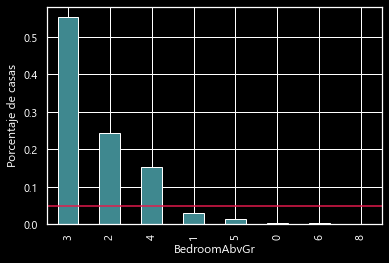

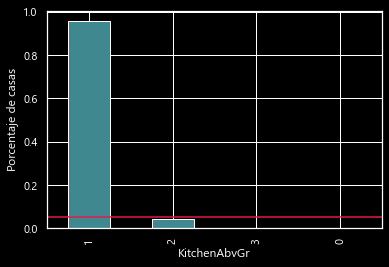

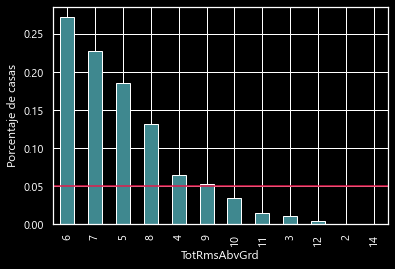

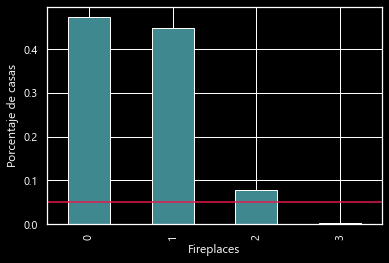

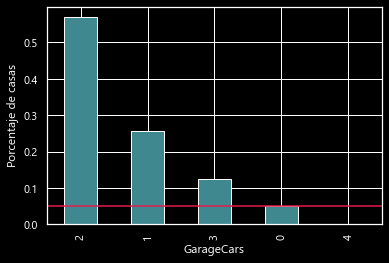

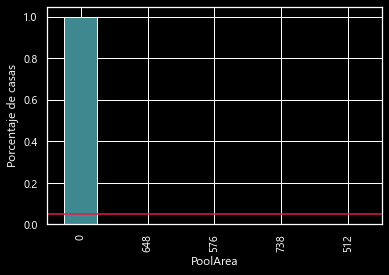

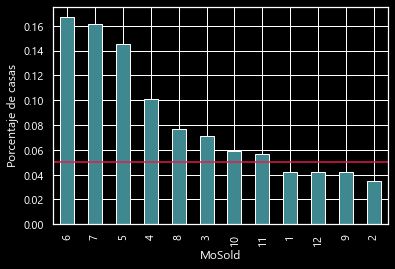

In [23]:
plot_categories(X_train, discrete)

In [24]:
# Aquí fijaremos un mínimo de 5 para las de alta cardinalidad y un mínimo de 3 para las de baja cardinalidad.
discrete_high_cardinality = ['MSSubClass', 'OverallQual', 'OverallCond', 'TotRmsAbvGrd', 'MoSold']
discrete_low_cardinality = [cat for cat in discrete if cat not in discrete_high_cardinality]

### 3. Pipeline
A continuación juntamos todo y armo el pipeline que procesará el set de entrenamiento

In [25]:
# Ingeniería de variables
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.imputation import RandomSampleImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.imputation import AddMissingIndicator
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

house_pipe = Pipeline([

    # Imputación de datos ausentes - Sección 4
    ('missing_indicator', AddMissingIndicator(variables = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'] + categorical_less_than_5perc)),
    
    ('imputer_random_categorical', RandomSampleImputer(random_state = 25, variables = categorical_less_5perc_random)),

    ('imputer_most_frecuent_cat', CategoricalImputer(imputation_method = 'frequent', variables = categorical_less_5perc_most_frequent)),

    ('imputer_missing_categorical', CategoricalImputer(imputation_method = 'missing', variables = categorical_more_than_5perc)),

    ('imputer_random_numerical', RandomSampleImputer(random_state = 1337, variables = ['LotFrontage', 'GarageYrBlt'])),
    
    ('imputer_median_numerical', MeanMedianImputer(imputation_method = 'median', variables = ['MasVnrArea'])),
    
    # Codificación de variables categóricas - Sección 6
    ('rare_label_enc_cat_high_cardinality', RareLabelEncoder(tol = 0.05,
                         n_categories = 6, variables = categorical_high_cardinality)),
    
    ('rare_label_enc_cat_low_cardinality',RareLabelEncoder(tol = 0.05,
                         n_categories = 2, variables = categorical_low_cardinality)),
    
    ('rare_label_enc_disc_high_cardinality', RareLabelEncoder(tol = 0.05,
                         n_categories = 5, variables = discrete_high_cardinality)),
    
    ('rare_label_enc_disc_low_cardinality', RareLabelEncoder(tol = 0.05,
                         n_categories = 3, variables = discrete_low_cardinality)),
    
    ('categorical_enc', OneHotEncoder(variables = categorical + discrete, drop_last = True)),    
    
    # Discretiazación + Codificación
    ('discretisation', EqualWidthDiscretiser(bins = 10, return_object = True, variables = numerical)),
    
    ('encoding', OneHotEncoder(variables = numerical, drop_last = True)),

    # Escalamiento de variables
    
    # Dado que se ha convertido todas las variables numéricas a categóricas
    # y se han codificado en columnas One Hot, remuevo el escalador para
    # que no me perjudique el rendimiento del modelo
    
    # ('scaler', RobustScaler()),
    
    # Regresión
    ('lasso', Lasso(random_state=0))
])

In [26]:
# Ajustemos el Pipeline - conjunto de pasos de para el preprocesamiento y modelamiento
house_pipe.fit(X_train, y_train)

# Predicciones
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

In [27]:
# Performance del modelo:
print(f'MSE entrenamiento: %0.2f' % mean_squared_error(y_train, X_train_preds))
print(f'RMSE entrenamiento: %0.2f' % np.sqrt(mean_squared_error(y_train, X_train_preds)))
print(f'R2 entrenamiento: %0.4f'% r2_score(y_train, X_train_preds))
print()
print(f'MSE prueba: %0.2f' % mean_squared_error(y_test, X_test_preds))
print(f'RMSE prueba: %0.2f' % np.sqrt(mean_squared_error(y_test, X_test_preds)))
print(f'R2 prueba: %0.4f' % r2_score(y_test, X_test_preds))

MSE entrenamiento: 356111354.50
RMSE entrenamiento: 18870.91
R2 entrenamiento: 0.9422

MSE prueba: 1015316586.62
RMSE prueba: 31864.03
R2 prueba: 0.8530


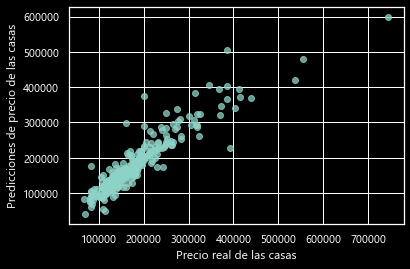

In [28]:
# Grafiquemos las predicciones vs. los valores reales
plt.scatter(y_test, X_test_preds, alpha=0.75)
plt.xlabel('Precio real de las casas')
plt.ylabel('Predicciones de precio de las casas')
plt.grid()
plt.show();